In [30]:
from nltk.corpus import stopwords
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# load all metadata

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [122]:
#Cargamos los datos
data = pd.read_csv('justice.csv')
x_train = data['facts']
y_train1 = data['first_party_winner']
y_train2 = data['issue_area']

In [123]:
def getLabels(Y):
    names = []
    newY =  []
    for i in Y:
        if i not in names:
            names.append(i)
        newY.append(names.index(i))
    return newY, names

In [124]:
y_train1_labels, y_train1_names = getLabels(y_train1)

y_train2_labels, y_train2_names = getLabels(y_train2)


In [125]:
#Elimina signos de puntuacion y todo a minusculas
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(x_train))

In [126]:
#Eliminamos las stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

In [127]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

In [128]:
#Lematizamos
def lemmatization(texts):
    texts_out = []
    for text in texts:
        lemText = []
        for sent in text:
            stemmed = ps.stem(sent)
            lemText.append(lem.lemmatize(stemmed))
        texts_out.append(lemText)
    return texts_out

data_lemmatized = lemmatization(data_words_nostops)

In [129]:
def get_topicModeling(data, n_topics):
    #Topic modeling
    id2word = corpora.Dictionary(data)
    texts = data
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=100, passes=10, eval_every=None)
    count = 0
    topics=[]
    for i in lda_model.print_topics():
        topics.append(i)
        count += 1
    return lda_model,corpus,topics
model, corpus, topics = get_topicModeling(data_lemmatized,100)

KeyboardInterrupt: 

In [84]:
def get_vectorized(model, corpus):
    #Hay que cambiar el n_topics por el numero de topics del LDA
    n_topics = model.num_topics
    vectorized = []
    count = 0
    #Recorrer los documentos
    for i in model[corpus]:
        #Inicializar index como lista de ceros, de longitud 'n_topics'
        index = [0]*n_topics
        #Recorrer cada palabra de cada documento
        for n in i:
            #En index[8] guardamos la informacion del tópico 8
            index[n[0]] = n[1]
        vectorized.append(index)
    vectorized = pd.DataFrame(vectorized)
    #Filas documentos (facts)
    #Columnas topics
    return vectorized
vectorized = get_vectorized(model,corpus)
print(vectorized)

            0    1        2    3         4         5    6         7   \
0     0.000000  0.0  0.00000  0.0  0.000000  0.000000  0.0  0.000000   
1     0.000000  0.0  0.00000  0.0  0.000000  0.000000  0.0  0.077054   
2     0.000000  0.0  0.00000  0.0  0.000000  0.000000  0.0  0.000000   
3     0.000000  0.0  0.00000  0.0  0.000000  0.063475  0.0  0.000000   
4     0.000000  0.0  0.00000  0.0  0.000000  0.000000  0.0  0.000000   
...        ...  ...      ...  ...       ...       ...  ...       ...   
3298  0.000000  0.0  0.00000  0.0  0.000000  0.000000  0.0  0.000000   
3299  0.000000  0.0  0.00000  0.0  0.000000  0.559386  0.0  0.000000   
3300  0.000000  0.0  0.19478  0.0  0.137725  0.000000  0.0  0.000000   
3301  0.000000  0.0  0.00000  0.0  0.000000  0.000000  0.0  0.000000   
3302  0.096704  0.0  0.00000  0.0  0.185930  0.000000  0.0  0.000000   

            8    9   ...        90   91   92        93   94   95   96  \
0     0.000000  0.0  ...  0.000000  0.0  0.0  0.305376  0.0  0

In [40]:
from wordcloud import WordCloud
def word_cloud_documents(data, nDocumento):
    #Word cloud de documento 3298

    string = ','.join(data[nDocumento])

    wordcloud = WordCloud(background_color="white", max_words=len(data[nDocumento]), contour_width=3, contour_color='steelblue')
    wordcloud.generate(string)
    wordcloud.to_image()

In [41]:
# WordCloud del topico 15
def word_cloud_topics(topics, nTopics):
    l = topics[nTopics][1]

    l = l.split("+")

    lista =[]
    for x in l:
        numero, palabra = x.split('*')
        palabra = palabra.split('"')[1]
        i=0
        while i < float(numero)*100:
            lista.append(palabra)
            i+=1
    lista = ','.join(lista)

    wordcloud = WordCloud(background_color="white", max_words=len(topics[nTopics][1]), contour_width=3, contour_color='steelblue')
    wordcloud.generate(lista)
    wordcloud.to_image()


In [94]:
#Comparar dimensiones antes y después de hacer el pca
from sklearn.decomposition import  PCA

def get_PCA(data, nPCA):
    print("Before:", data.shape)
    #pca = PCA(n_components='mle', svd_solver='full')
    pca = PCA(n_components=nPCA)
    pca.fit(data)
    data_PCA= pca.transform(data)
    print("After:", data_PCA.shape)
    return data_PCA, pca
data_PCA, pca = get_PCA(vectorized,2)

Before: (3303, 100)
After: (3303, 2)


In [ ]:
#Distancia euclídea
import math
def getDist(clust1, clust2):
    dist = 0
    #Sumatorio de distancias euclideas
    for i in range(len(clust1)):
        #Calcular la distancia euclídea de cada i
        dist += math.sqrt((clust1[i] - clust2[i])**2)
    return dist

In [ ]:
#Generar la matriz con las distancias entre cada cluster
def getDistances(clusters):
    distances = []
    for clust1 in range(len(clusters)):
        #Convertir a numpy
        dist_clust1 = [np.NAN] * (clust1+1)
        for clust2 in [t for t in range(len(clusters)) if t > clust1]:
            dist_clust1.append(getDist(clusters[clust1], clusters[clust2]))
        distances.append(np.array(dist_clust1))
    distances = np.array(distances)
    return distances

In [45]:
#Agrupa la fila y columna de la matriz de distancias, con la menor distancia
def hierarchical_clustering(data):
    distances = getDistances(data)
    #Número de iteración, la distancia y los clusters
    k_clusters = [0,0,[[i] for i in range(len(data))]]

    tree = [[],[]]
    tree_aux = [i for i in range(len(data))]
    list_of_clusters = []
    list_of_clusters.append([k_clusters[0],k_clusters[1],k_clusters[2].copy()])
    it = 0
    n_inst = len(data)

    print("Starting")
    #Recorrer hasta que sólo queda un cluster
    while len(distances) > 1:
        ind1,ind2 = np.unravel_index(np.nanargmin(distances), distances.shape)
        #Coger la distancia mínima
        min_dist = np.nanmin(distances)
        #Eliminar y agrupar las columnas y filas que contengan esa distancia mínima
        delete = max(ind1,ind2)
        replace = min(ind1,ind2)
        #Calcular la distancia máxima
        for i in [t for t in range(len(distances)) if t != ind1 and t != ind2]:
            distance = np.nanmax([distances[ind1][i],distances[ind2][i],distances[i][ind1],distances[i][ind2]])
            if replace < i:
                distances[replace][i] = distance
            else:
                distances[i][replace] = distance
        #Eliminar fila y columna
        distances = np.delete(distances, delete,1)
        distances = np.delete(distances, delete,0)
        #Añadir los valores para el dendograma 
        tree[0].append([tree_aux[replace],tree_aux[delete]])
        tree[1].append(min_dist)
        tree_aux[replace] = it + n_inst
        tree_aux.remove(tree_aux[delete])
        #Número de iteración
        k_clusters[0] = it
        #La distancia mínima
        k_clusters[1] = min_dist
        #Sustituir por el sustituto + el borrado
        k_clusters[2][replace] = k_clusters[2][replace]+k_clusters[2][delete]
        #Borrar el borrado
        k_clusters[2].remove(k_clusters[2][delete])
        it += 1

        list_of_clusters.append([k_clusters[0],k_clusters[1],k_clusters[2].copy()])

    print("End")
    return list_of_clusters,tree
list_of_clusters, tree = hierarchical_clustering(data_PCA)

Starting
End


In [48]:
#Dado un número de clusters, devuelve a que cluster pertenece cada instancia, 
#distancia y en cada cluster qué instancias hay
def get_nClusters(list_clusters, k):
    n_inst = len(list_clusters[0][2])
    for clusters in list_clusters:
        if len(clusters[2]) == k:
            kClusters = [0] * n_inst
            dist = clusters[1]
            i = 0
            for clust in clusters[2]:
                for c in clust:
                    kClusters[c] = i
                i += 1
            return kClusters,dist,clusters[2]
    return [], 0


k_labels, dist, k_clusters = get_nClusters(list_of_clusters,2)

In [49]:
#Dado una distancia máxima, devuelve a que cluster pertenece cada instancia, 
#el número de clusters y en cada cluster qué instancias hay
def get_distClusters(list_clusters, d):
    n_inst = len(list_clusters[0][2])
    clusters_aux = list_clusters[0]
    for clusters in list_clusters:
        if clusters[1] > d:
            distClusters = [0] * n_inst
            nClusters = len(clusters)
            i = 0
            for clust in clusters_aux[2]:
                for c in clust:
                    distClusters[c] = i
                i += 1
            return distClusters, nClusters, clusters[2]
        clusters_aux = clusters
    return [], 0


dist_labels, nClusters, dist_clusters = get_distClusters(list_of_clusters,1)

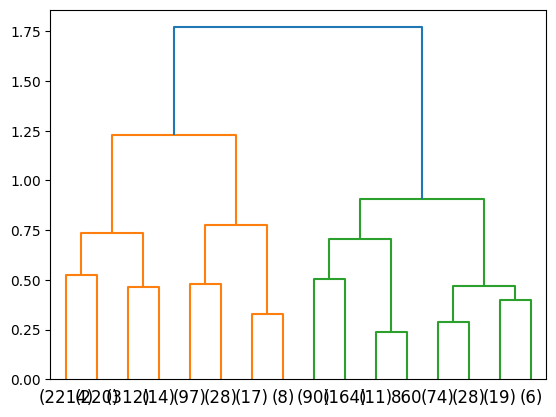

In [50]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(tree, labels ,mode , p, threshold):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(len(tree[0]))
    n_samples = len(labels)
    for i, merge in enumerate(tree[0]):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [tree[0], tree[1], counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode=mode, p=p , color_threshold=threshold)


#mode : "lastp" p numero de nodos hoja, "level" p profundidad del dendograma.
#threshold : la linea que separa los clusters.
plot_dendrogram(tree,data_PCA,mode ="level", p=3, threshold=dist+0.01)

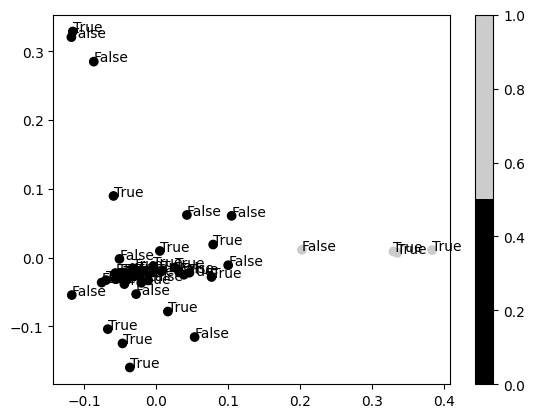

In [59]:
import matplotlib.pyplot as plt

def get_plot(data, labels, train, nSamples):

    samples = nSamples

    # Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
    # Color del punto: cluster
    sc = plt.scatter(data[:samples,0],data[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', max(labels) + 1),c=labels[:samples])
    plt.colorbar()
    # Etiqueta numérica: clase
    for i in range(samples):
        plt.text(data[i,0], data[i,1], train[i])
get_plot(data_PCA, k_labels, y_train1, 50)

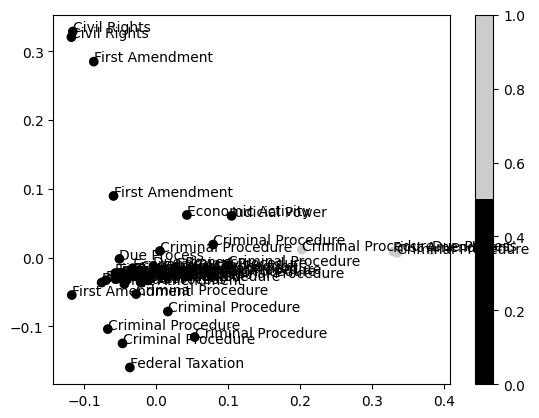

In [60]:
get_plot(data_PCA, k_labels, y_train2, 50)

In [61]:
def get_Centers(clusters, data):
    centers = []
    for x in range((max(clusters) + 1)):
        centers.append([])

    n_inst = [0] * (max(clusters) + 1)
    for i in range(len(clusters)):
        for i2 in range(len(data[0])):
            if len(centers[clusters[i]]) <= i2:
                centers[clusters[i]].append(data[i][i2])
            else:
                centers[clusters[i]][i2]+=data[i][i2]
        n_inst[clusters[i]] += 1

    for i in range((max(clusters) + 1)):
        for i2 in range(len(data[0])):
            centers[i][i2] = centers[i][i2] / n_inst[i]

    return centers

For n_clusters = 2 The average silhouette_score is : 0.6053142809297767
For n_clusters = 3 The average silhouette_score is : 0.6606867461694833
For n_clusters = 4 The average silhouette_score is : 0.5678619223254755
For n_clusters = 5 The average silhouette_score is : 0.562953281450919
For n_clusters = 6 The average silhouette_score is : 0.38098305444220476
For n_clusters = 7 The average silhouette_score is : 0.38111598985451106
For n_clusters = 8 The average silhouette_score is : 0.3748219921656967


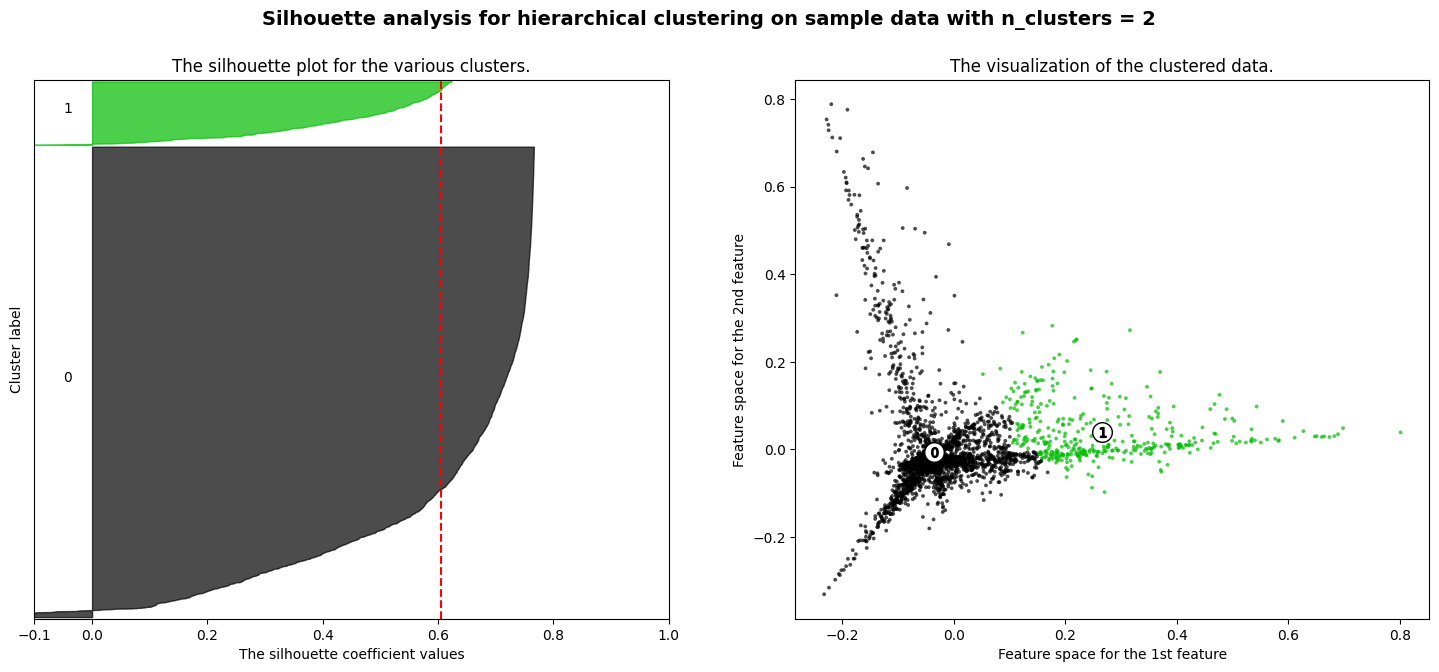

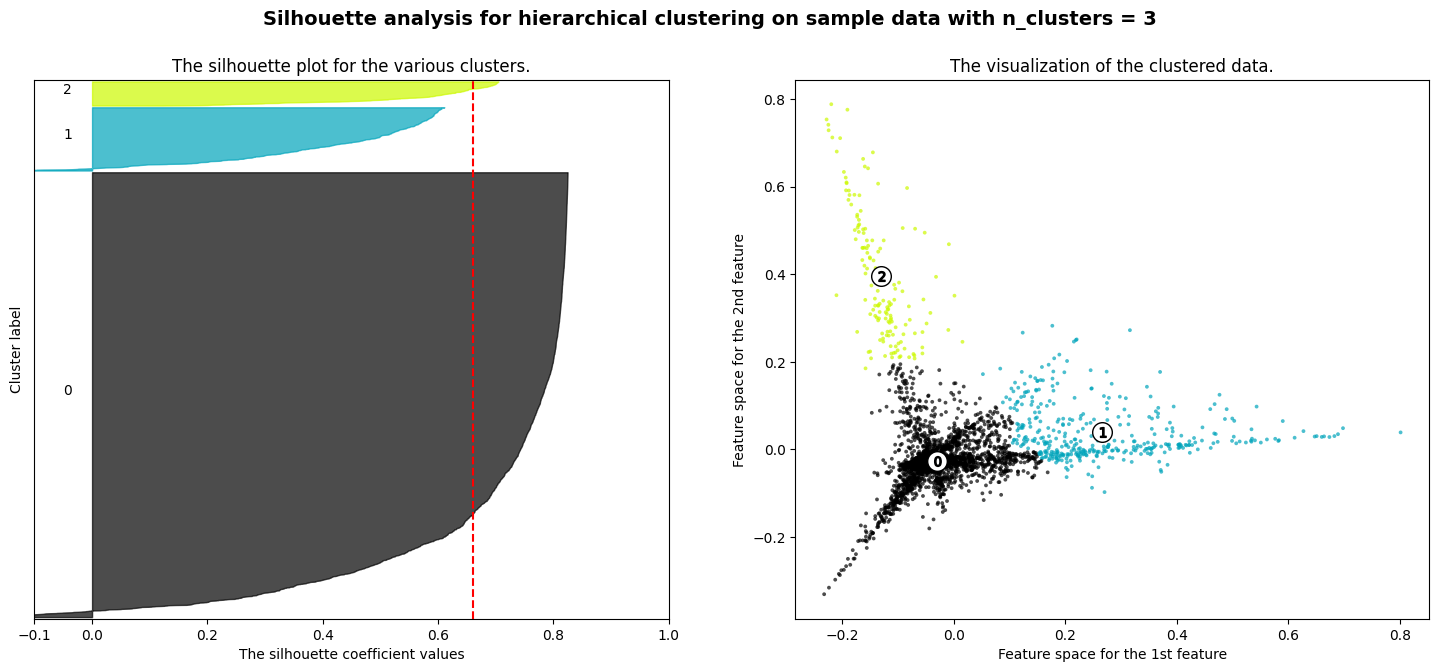

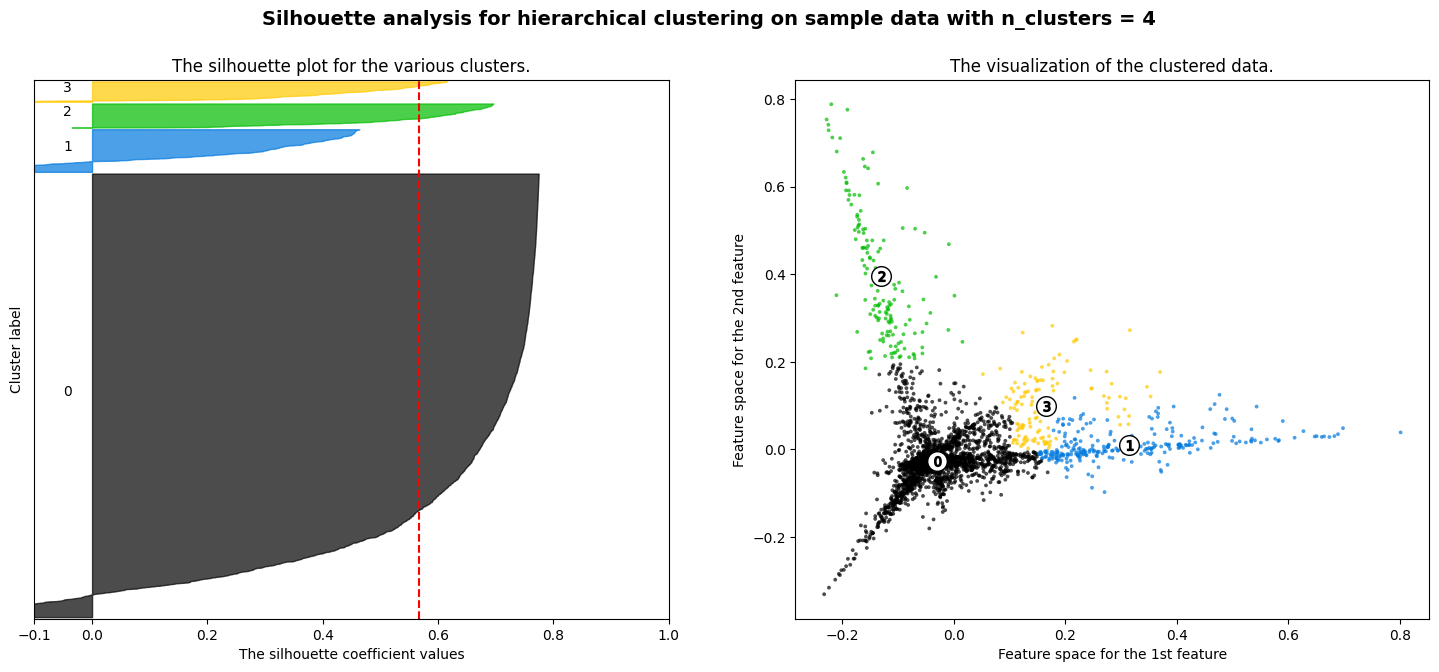

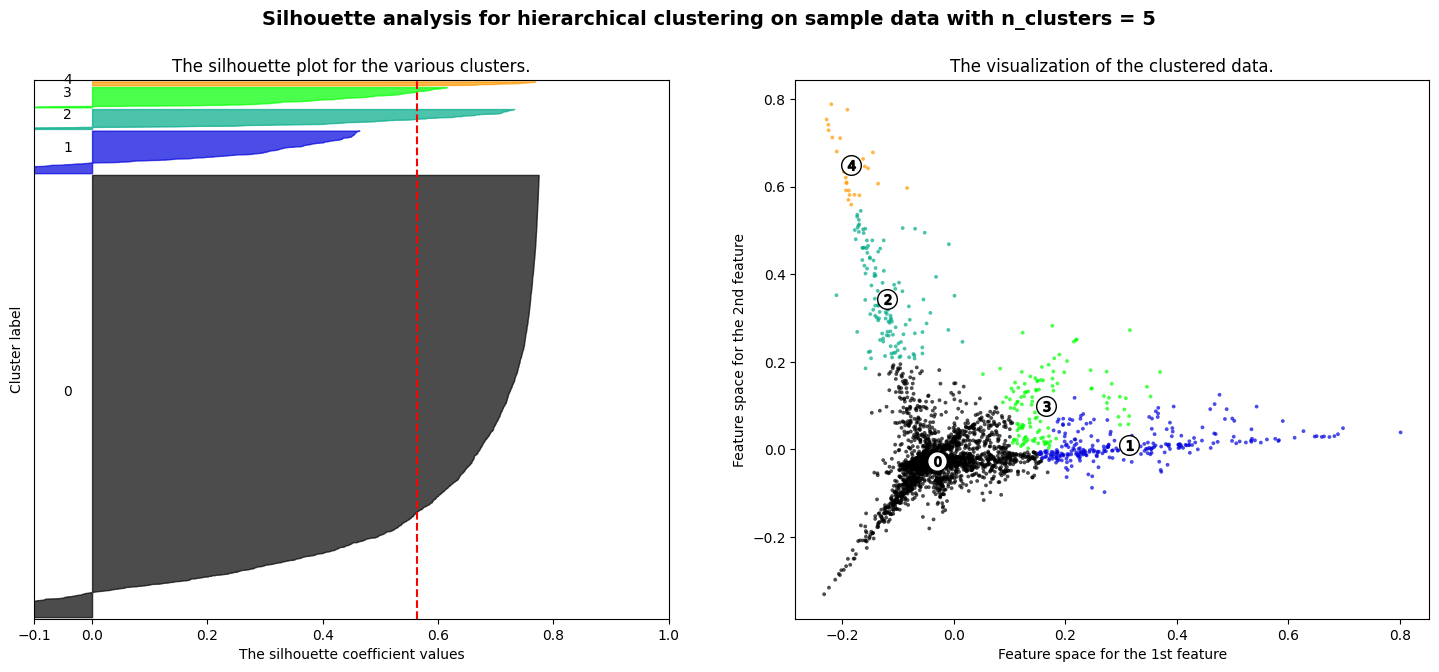

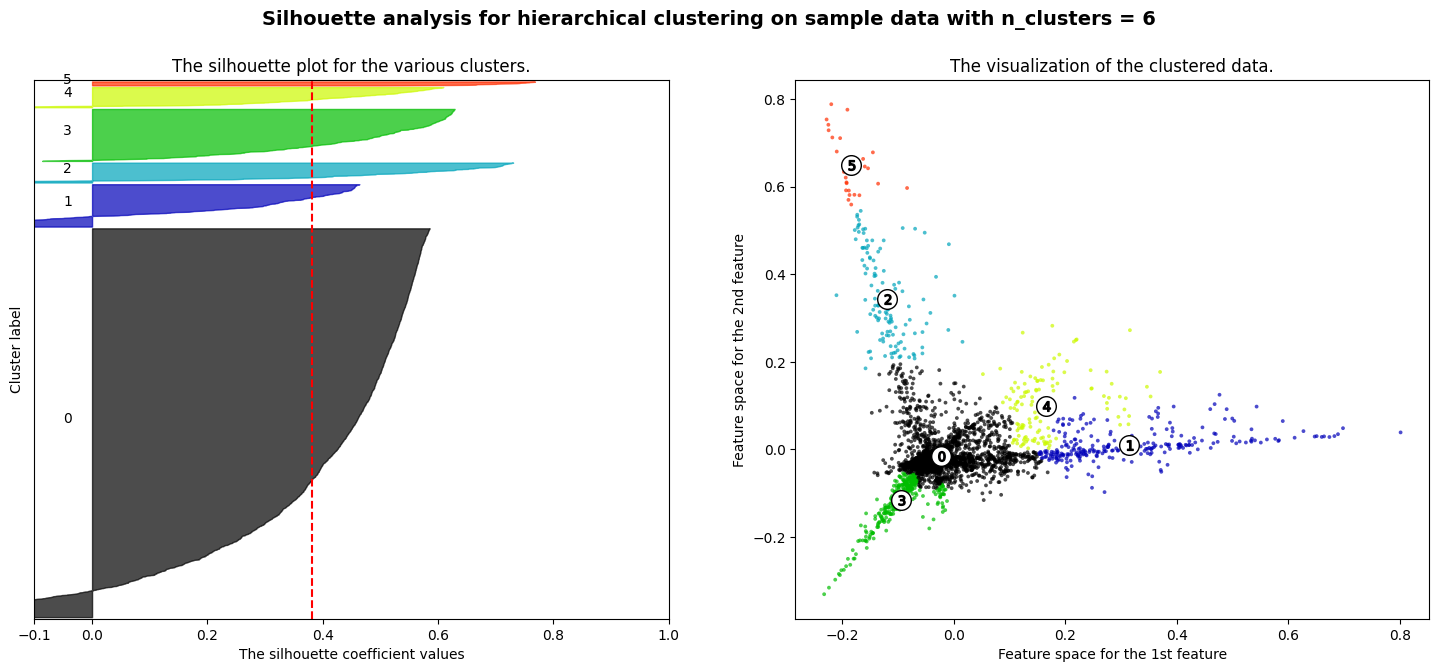

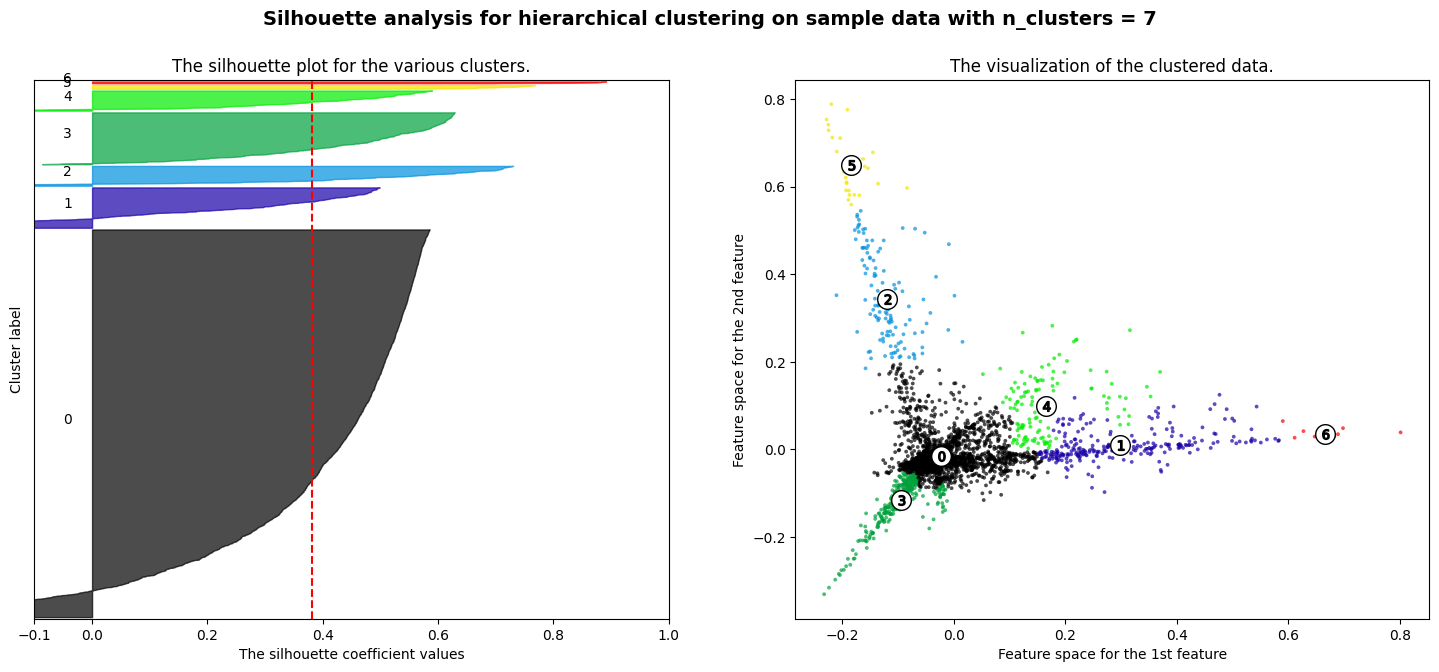

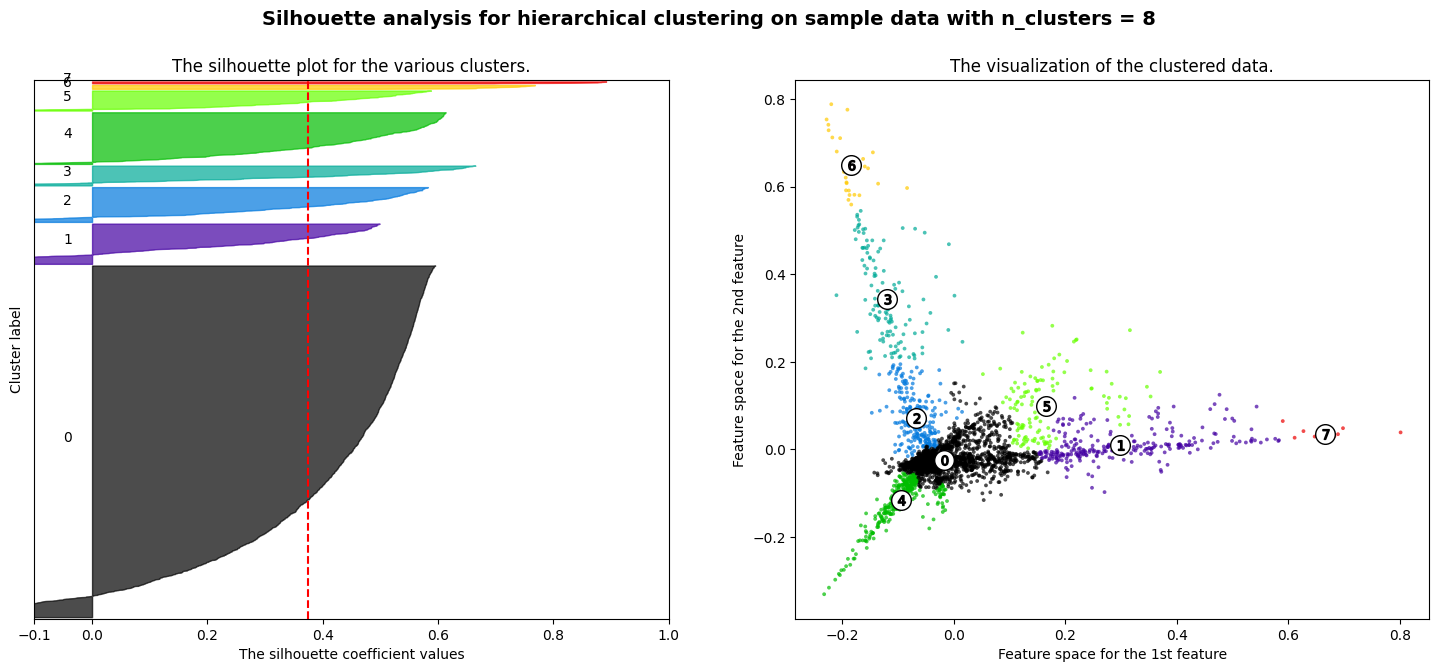

In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def get_silhouette(data, list_of_clusters, range_n_clusters):

    silhouettes = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        cluster_labels_og, dist, k_clusters = get_nClusters(list_of_clusters,n_clusters)
        cluster_labels = np.array(cluster_labels_og)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = get_Centers(cluster_labels_og, data_PCA)
        centers = np.array(centers)
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for hierarchical clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()
get_silhouette(data_PCA, list_of_clusters, range(2,9,1))

In [70]:
k_labels,dist, k_clusters = get_nClusters(list_of_clusters, 5)
silhouette_score(data_PCA, k_labels)

0.562953281450919

In [71]:
#Calcular centroides
def centroides(clusters,data):
    centers = []
    for x in range((len(clusters))):
        centers.append([])

    n_inst = [0] * (len(clusters))
    for i in range(len(clusters)):
        for y in clusters[i]:
            for i2 in range(len(data[0])):
                if len(centers[i]) <= i2:
                    centers[i].append(data[y][i2])
                else:
                    centers[i][i2]+=data[y][i2]
            n_inst[i] += 1

    for i in range((len(clusters))):
        for i2 in range(len(data[0])):
            centers[i][i2] = centers[i][i2] / n_inst[i]

    return centers

In [119]:
def get_new_inst(inst, model, pca):
    #Eliminar carácteres extraños
    ins_words = list(sent_to_words([inst]))
    #Eliminar las stop words
    ins_words_nostops = remove_stopwords(ins_words)
    #Lematizar
    ins_lemmatized = lemmatization(ins_words_nostops)
    #Vectorizar
    id2word = corpora.Dictionary(ins_lemmatized)
    texts = ins_lemmatized
    ins_corpus = [id2word.doc2bow(text) for text in texts]
    model[ins_corpus]

    count = 0
    #Inicializar index como lista de ceros, de longitud 'n_topics'
    ins_vectorized = [0]*model.num_topics
    #Recorrer cada palabra de cada documento
    for n in model[ins_corpus][0]:
        #En index[8] guardamos la informacion del tópico 8
        ins_vectorized[n[0]] = n[1]

    #PCA
    ins_PCA = pca.transform([ins_vectorized])[0]
    #Calcular los centroides
    centers = centroides(k_clusters,data_PCA)
    #Calcular la menor distancia a los centroides
    dist=10000000
    clus=0
    cont=0
    for i in centers:
        x = getDist(i,ins_PCA)
        if x < dist:
            dist = x
            clus = cont
        cont+=1
    print(dist,clus)
get_new_inst(x_train[568], model, pca)

0.15038269903290813 3


In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Confusion matrix
def get_cm(Y_labels, predictions, names):
    # El atributo generado por K-means es int, hay que pasarlos a string
    to_string = lambda x : str(x)
    # Obtener matriz de confusión Class to clustering eval
    cm = confusion_matrix(predictions, Y_labels)
    #Borrar la columnas vacias
    columns = cm.any(axis=0)
    delete = []
    for i in range(len(columns)):
        if not columns[i]:
            delete.append(i)
    cm = np.delete(cm, delete, axis=1)


    ylabels=[None for i in range(len(cm))]
    ymax=[0 for i in range(len(cm))]
    cm_copy = cm.copy()
    for i in range(19):
        cont=0
        for i in cm_copy:
            if ylabels[cont] == None:
                if i.argmax() in ylabels:
                    x=ymax[i.argmax()]
                    y=i.max()
                    if y > x[1] :
                        ylabels[x[0]] = None
                        ylabels[cont] = i.argmax()
                        ymax[i.argmax()]=(cont,i.max())
                        cm_copy[x[0]][i.argmax()]=0
                    else:
                        cm_copy[cont][i.argmax()]=0
                else:
                    ylabels[cont] = i.argmax()
                    ymax[i.argmax()]=(cont,i.max())
            cont=cont+1

    cm_new = [[] for i in range(len(cm))]
    cont = 0
    used = [i for i in range(len(cm))]
    cont_down = 0
    for i in ylabels:
        if i is not None:
            cm_new[i] = cm[cont].tolist()
            used.remove(cont)
        elif cont_down < len(cm)- len(cm[0]):
            cm_new[len(cm)-cont_down - 1] = cm[cont].tolist()
            used.remove(cont)
            cont_down +=1
        cont += 1

    for i in range(len(cm_new)):
        if not cm_new[i]:
            cm_new[i] = cm[used[0]]
            ylabels[used[0]] = i
            used.remove(used[0])

    new_ylabels = [None] * len(ylabels)
    for i in range(len(ylabels)):
        if ylabels[i] is not None:
            new_ylabels[ylabels[i]] = names[ylabels[i]]
    ylabels = new_ylabels


    # Mapa de calor a partir de la matriz de confusion
    ax = sns.heatmap(cm_new, annot=True, fmt="d", cmap="Blues", xticklabels=names, yticklabels=ylabels)
    return cm_new

#El valor real es el de abajo

In [815]:
def get_accuracy_unorder(cm):
    total = 0
    correct = 0
    row = 0
    for i in cm:
        column = 0
        for n in i:
            total += n
            if column == row and column < len(cm[0]):
                correct += n
            column += 1
        row += 1
    print(total, correct , correct/total)


3303 828 0.2506811989100817


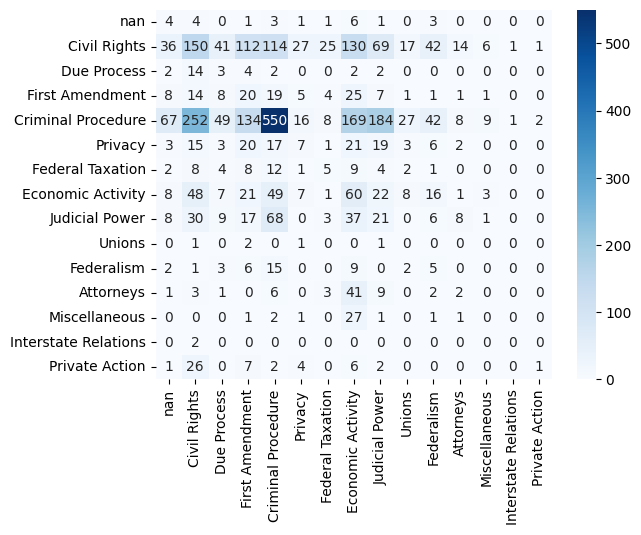

In [823]:
k_labels,dist, k_clusters = get_nClusters(list_of_clusters,15)
cm = get_cm(y_train2_labels, k_labels, y_train2_names)
get_accuracy_unorder(cm)

3303 2123 0.6427490160460188


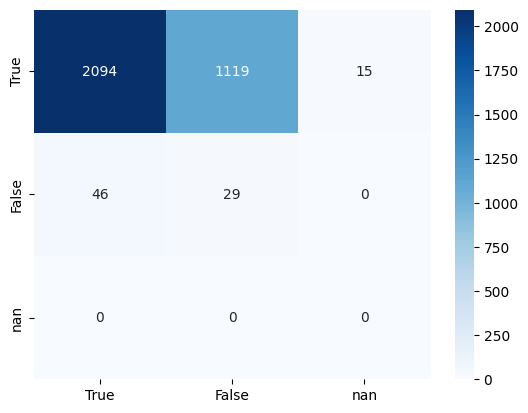

In [818]:
k_labels,dist, k_clusters = get_nClusters(list_of_clusters,2)
cm = get_cm(y_train1_labels,k_labels, y_train1_names)
get_accuracy_unorder(cm)

In [138]:
from sklearn.metrics import accuracy_score
def getAll(range_topics, range_PCA, range_clusters, data):
    scores = []
    for t in range_topics:
        model,corpus,topics = get_topicModeling(data, t)
        vectorized = get_vectorized(model,corpus)
        for p in [x for x in range_PCA if x <= t]:
            data_PCA,pca = get_PCA(vectorized,p)
            list_of_clusters,tree = hierarchical_clustering(data_PCA)
            for c in range_clusters:
                k_labels,dist,k_clusters = get_nClusters(list_of_clusters,c)
                sj = silhouette_score(data_PCA,k_labels)
                acc1 = accuracy_score(k_labels,y_train1_labels)
                acc2 = accuracy_score(k_labels,y_train2_labels)
                scores.append([c,dist,p,t,sj,acc1,acc2])
                print(scores)
    return scores

scores = getAll(range(2,10,2), range(2,22,5), range(2,10,2),data_lemmatized)
print(scores)

Before: (3303, 2)
After: (3303, 2)
Starting
End
[[2, 0.9188353374559897, 2, 2, 0.7851003153755364, 0.51952770208901, 0.08628519527702089]]
[[2, 0.9188353374559897, 2, 2, 0.7851003153755364, 0.51952770208901, 0.08628519527702089], [4, 0.488066701700837, 2, 2, 0.7211694590623722, 0.16651528913109295, 0.1320012110202846]]
[[2, 0.9188353374559897, 2, 2, 0.7851003153755364, 0.51952770208901, 0.08628519527702089], [4, 0.488066701700837, 2, 2, 0.7211694590623722, 0.16651528913109295, 0.1320012110202846], [6, 0.3267309992950932, 2, 2, 0.7211004735974487, 0.14774447471995156, 0.06388132001211021]]
[[2, 0.9188353374559897, 2, 2, 0.7851003153755364, 0.51952770208901, 0.08628519527702089], [4, 0.488066701700837, 2, 2, 0.7211694590623722, 0.16651528913109295, 0.1320012110202846], [6, 0.3267309992950932, 2, 2, 0.7211004735974487, 0.14774447471995156, 0.06388132001211021], [8, 0.22815145216706267, 2, 2, 0.7203833207790276, 0.10838631547078413, 0.09536784741144415]]
Before: (3303, 4)
After: (3303, 2)



KeyboardInterrupt

